# Data Validation and Exploration

This notebook performs the following tasks on the dataset:
1. Check for missing values
2. Identify duplicate entries
3. Validate data types
4. Analyze Score distribution
5. Calculate text length statistics
6. Text Content Analysis
7. Metadata Relationships

In [ ]:
# Import necessary libraries
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [14]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/khoa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/khoa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# Import utilities from src/data/utils.py
import sys
sys.path.append('..')
import src.data.utils as utils

# Remove un-used column
utils.remove_columns(
    input_file="../dataset/raw/Reviews.csv", 
    output_file="../dataset/processed/Reviews_removed_columns.csv"
)

# Load the dataset
df = pd.read_csv('../dataset/processed/Reviews_removed_columns.csv')

# Display the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Processed dataset saved to ../dataset/processed/Reviews_removed_columns.csv
Dataset shape: (20038, 4)


,Id,Score,Summary,Text
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,5,Great taffy,Great taffy at a great price. There was a wid...


## 1. Check for Missing Values

In [16]:
# Check for missing values in the Score, Summary, and Text columns
missing_values = df[['Score', 'Summary', 'Text']].isnull().sum()
missing_percentage = (df[['Score', 'Summary', 'Text']].isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

missing_df

,Missing Values,Percentage (%)
Score,0,0.0
Summary,0,0.0
Text,0,0.0


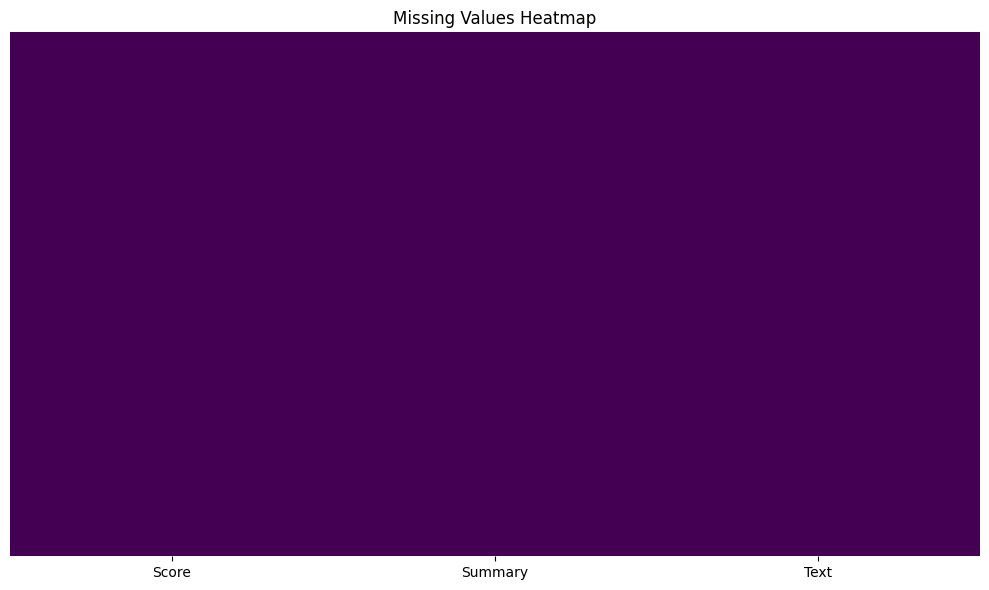

In [17]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Score', 'Summary', 'Text']].isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

The uniform coloring means every value is False (no nulls). In other words, there are no missing values in 'Score', 'Summary', or 'Text'.

## 2. Identify Duplicate Entries

In [18]:
# Check for duplicate entries
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Check for duplicates based on specific columns (excluding Id)
content_duplicates = df.duplicated(subset=['Score', 'Summary', 'Text']).sum()
print(f"Number of content duplicates (same Score, Summary, and Text): {content_duplicates}")

# Display some examples of duplicates if they exist
if content_duplicates > 0:
    print("\nExamples of content duplicates:")
    duplicate_mask = df.duplicated(subset=['Score', 'Summary', 'Text'], keep=False)
    display(df[duplicate_mask].sort_values(by=['Score', 'Summary']).head(10))

Number of duplicate rows: 0
Number of content duplicates (same Score, Summary, and Text): 695

Examples of content duplicates:


,Id,Score,Summary,Text
11100,11101,1,According to the Manufacturer's own website th...,Ingredients on Deep River Snacks's website are...
20009,20010,1,According to the Manufacturer's own website th...,Ingredients on Deep River Snacks's website are...
7246,7247,1,Almost no detectable flavor,Unfortunately I am completely disappointed wit...
11267,11268,1,Almost no detectable flavor,Unfortunately I am completely disappointed wit...
8327,8328,1,Bad Cups,"Coffee tastes great, but the cups get torn apa..."
9036,9037,1,Bad Cups,"Coffee tastes great, but the cups get torn apa..."
8335,8336,1,Beware! Flavored Coffee...,It sure would be nice if they stated ANYWHERE ...
9044,9045,1,Beware! Flavored Coffee...,It sure would be nice if they stated ANYWHERE ...
8584,8585,1,Cups Can Be Defective,"This is a good French roast coffee, although i..."
9293,9294,1,Cups Can Be Defective,"This is a good French roast coffee, although i..."


## 3. Validate Data Types

In [19]:
# Display current data types
print("Current data types:")
df.dtypes

Current data types:


Id          int64
Score       int64
Summary    object
Text       object
dtype: object

In [20]:
# Check if Score is numerical
try:
    pd.to_numeric(df['Score'])
    print("✅ Score column is numerical or can be converted to numerical")
except Exception as e:
    print(f"❌ Score column contains non-numerical values: {e}")
    # Find problematic entries
    problematic = [i for i, x in enumerate(df['Score']) if not pd.api.types.is_number(x)]
    if problematic:
        print(f"Problematic entries at indices: {problematic[:5]}...")
        display(df.iloc[problematic[:5]])

# Check if Summary and Text are strings
text_columns = ['Summary', 'Text']
for col in text_columns:
    if df[col].dtype == 'object':
        print(f"✅ {col} column is object type (string)")
    else:
        print(f"❌ {col} column is not object type: {df[col].dtype}")

✅ Score column is numerical or can be converted to numerical
✅ Summary column is object type (string)
✅ Text column is object type (string)


## 4. Analyze Score Distribution

In [21]:
# Create Score value counts and percentage
score_counts = df['Score'].value_counts().sort_index()
score_percentage = df['Score'].value_counts(normalize=True).sort_index() * 100

score_distribution = pd.DataFrame({
    'Count': score_counts,
    'Percentage (%)': score_percentage
})

score_distribution

,Count,Percentage (%)
Score,,
1,1829,9.127657
2,1122,5.599361
3,1652,8.244336
4,2840,14.173071
5,12595,62.855574


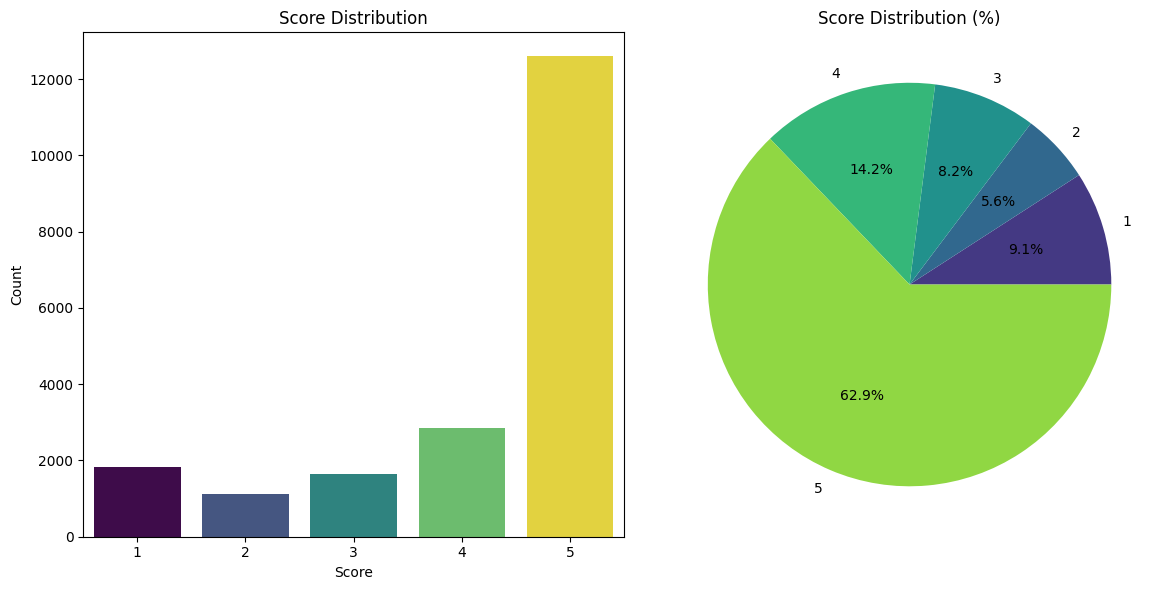

In [22]:
# Visualize Score distribution
plt.figure(figsize=(12, 6))

# Bar plot
plt.subplot(1, 2, 1)
sns.countplot(x='Score', data=df, palette='viridis', hue='Score', legend=False)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(score_counts)))
plt.title('Score Distribution (%)')

plt.tight_layout()
plt.show()

## 5. Calculate Text Length Statistics

In [23]:
# Calculate length of Summary and Text
df['Summary_Length'] = df['Summary'].apply(lambda x: len(str(x)))
df['Text_Length'] = df['Text'].apply(lambda x: len(str(x)))

# Calculate word count
df['Summary_Word_Count'] = df['Summary'].apply(lambda x: len(str(x).split()))
df['Text_Word_Count'] = df['Text'].apply(lambda x: len(str(x).split()))

# Display statistics
length_stats = pd.DataFrame({
    'Summary_Length': df['Summary_Length'].describe(),
    'Text_Length': df['Text_Length'].describe(),
    'Summary_Word_Count': df['Summary_Word_Count'].describe(),
    'Text_Word_Count': df['Text_Word_Count'].describe()
})

length_stats

,Summary_Length,Text_Length,Summary_Word_Count,Text_Word_Count
count,20038.000000,20038.000000,20038.000000,20038.000000
mean,23.420601,428.800279,4.097515,78.684100
std,14.066805,424.252529,2.591322,75.342191
min,1.000000,33.000000,1.000000,6.000000
25%,13.000000,179.000000,2.000000,33.000000
50%,20.000000,300.000000,4.000000,56.000000
75%,30.000000,523.000000,5.000000,97.000000
max,128.000000,10327.000000,31.000000,1751.000000


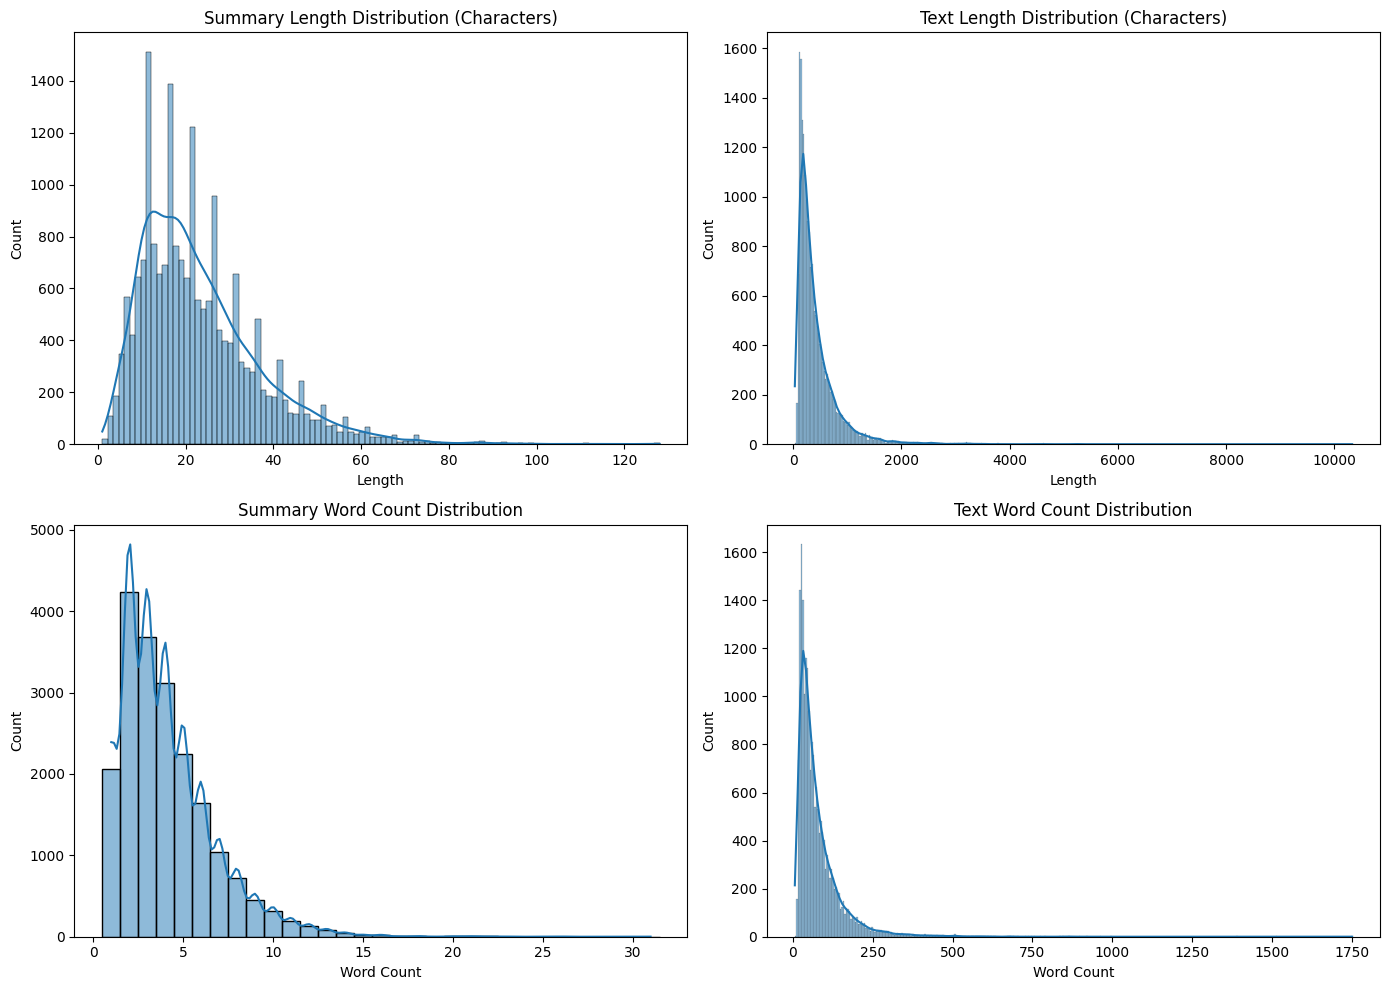

In [24]:
# Visualize text length distributions
plt.figure(figsize=(14, 10))

# Summary length histogram
plt.subplot(2, 2, 1)
sns.histplot(df['Summary_Length'], kde=True)
plt.title('Summary Length Distribution (Characters)')
plt.xlabel('Length')

# Text length histogram
plt.subplot(2, 2, 2)
sns.histplot(df['Text_Length'], kde=True)
plt.title('Text Length Distribution (Characters)')
plt.xlabel('Length')

# Summary word count histogram
plt.subplot(2, 2, 3)
sns.histplot(df['Summary_Word_Count'], kde=True, discrete=True)
plt.title('Summary Word Count Distribution')
plt.xlabel('Word Count')

# Text word count histogram
plt.subplot(2, 2, 4)
sns.histplot(df['Text_Word_Count'], kde=True)
plt.title('Text Word Count Distribution')
plt.xlabel('Word Count')

plt.tight_layout()
plt.show()

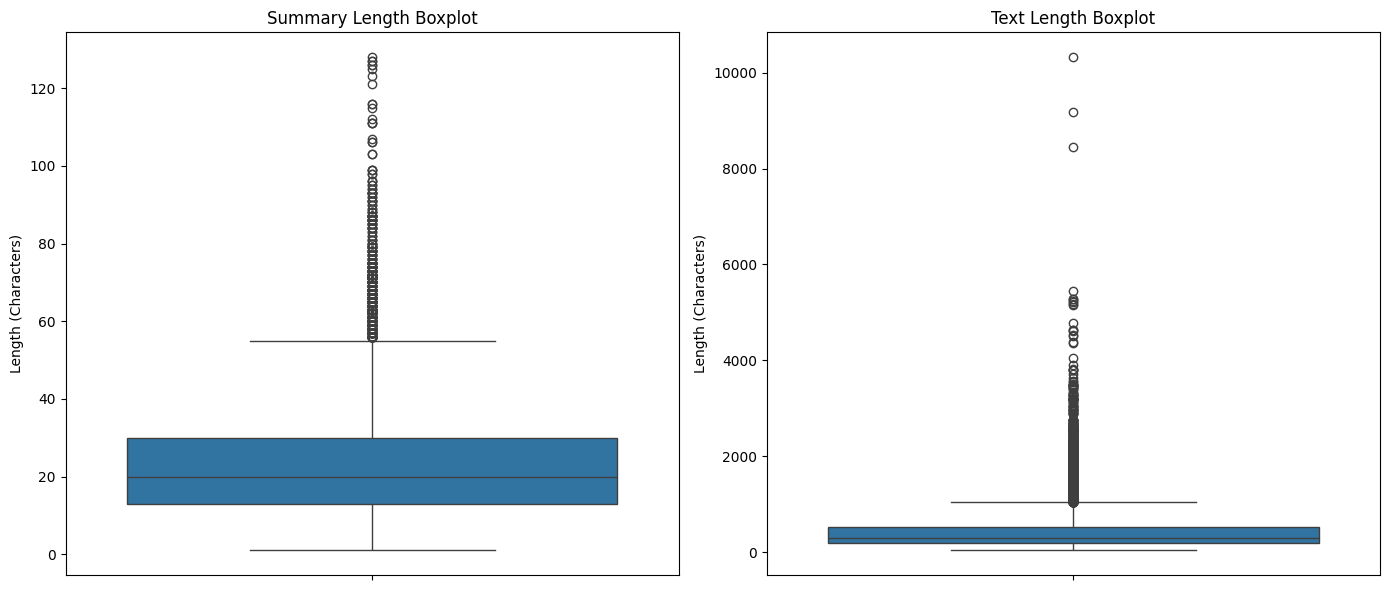

In [25]:
# Boxplot to show outliers
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['Summary_Length'])
plt.title('Summary Length Boxplot')
plt.ylabel('Length (Characters)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Text_Length'])
plt.title('Text Length Boxplot')
plt.ylabel('Length (Characters)')

plt.tight_layout()
plt.show()

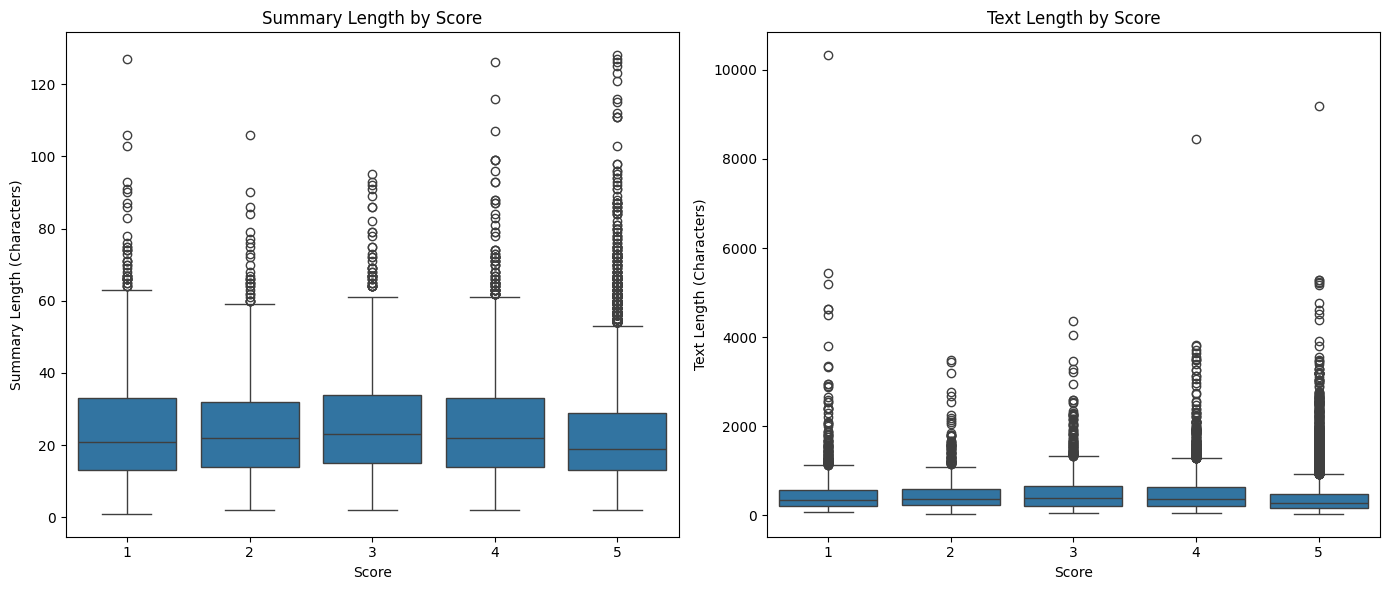

In [26]:
# Check for any relationship between Score and text lengths
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Score', y='Summary_Length', data=df)
plt.title('Summary Length by Score')
plt.ylabel('Summary Length (Characters)')

plt.subplot(1, 2, 2)
sns.boxplot(x='Score', y='Text_Length', data=df)
plt.title('Text Length by Score')
plt.ylabel('Text Length (Characters)')

plt.tight_layout()
plt.show()

## 6. Text Content Analysis

In this section, we analyze the text content including frequent words, compare vocabulary between high and low scores, and check for special characters/HTML tags.

### 6.1 Identify Frequent Words/N-grams Using Word Clouds

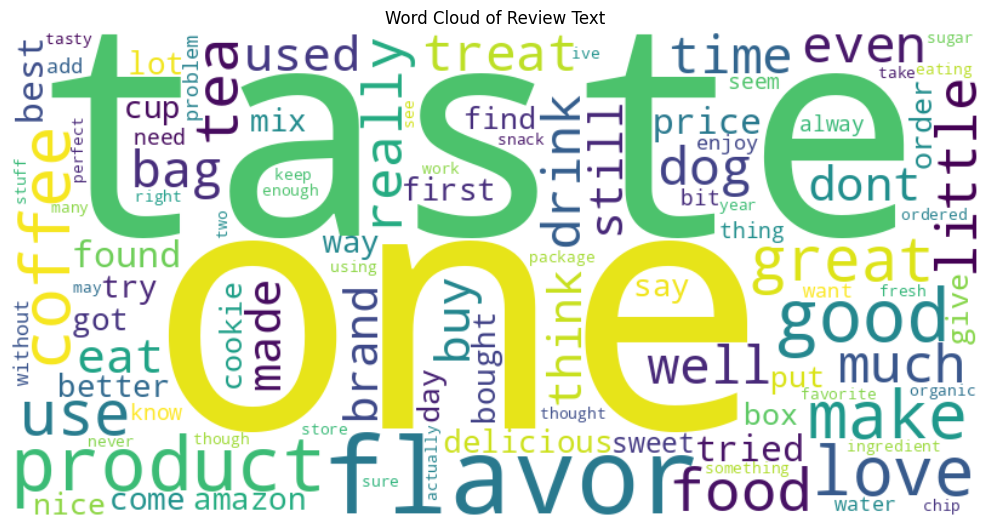

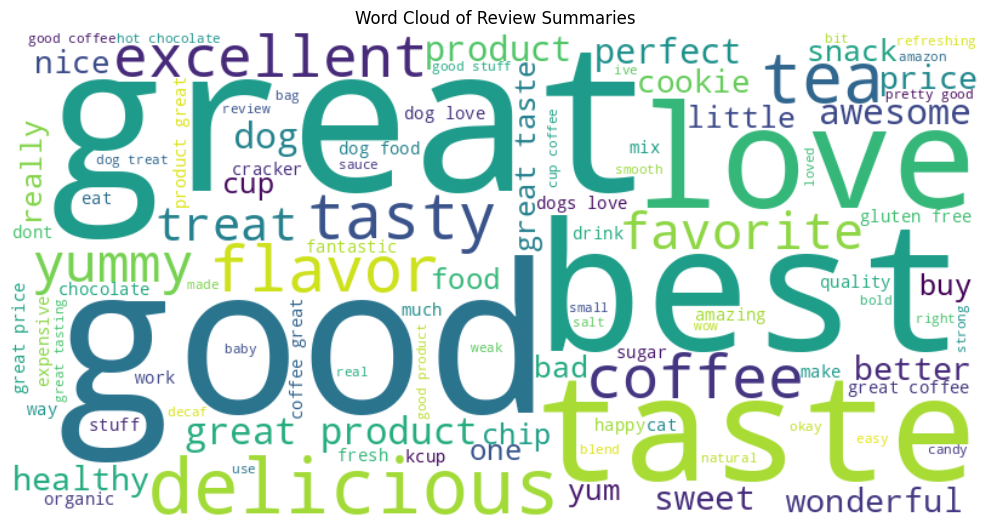

In [27]:
# Generate word clouds for all text
utils.generate_wordcloud(df['Text'], 'Word Cloud of Review Text')
utils.generate_wordcloud(df['Summary'], 'Word Cloud of Review Summaries')

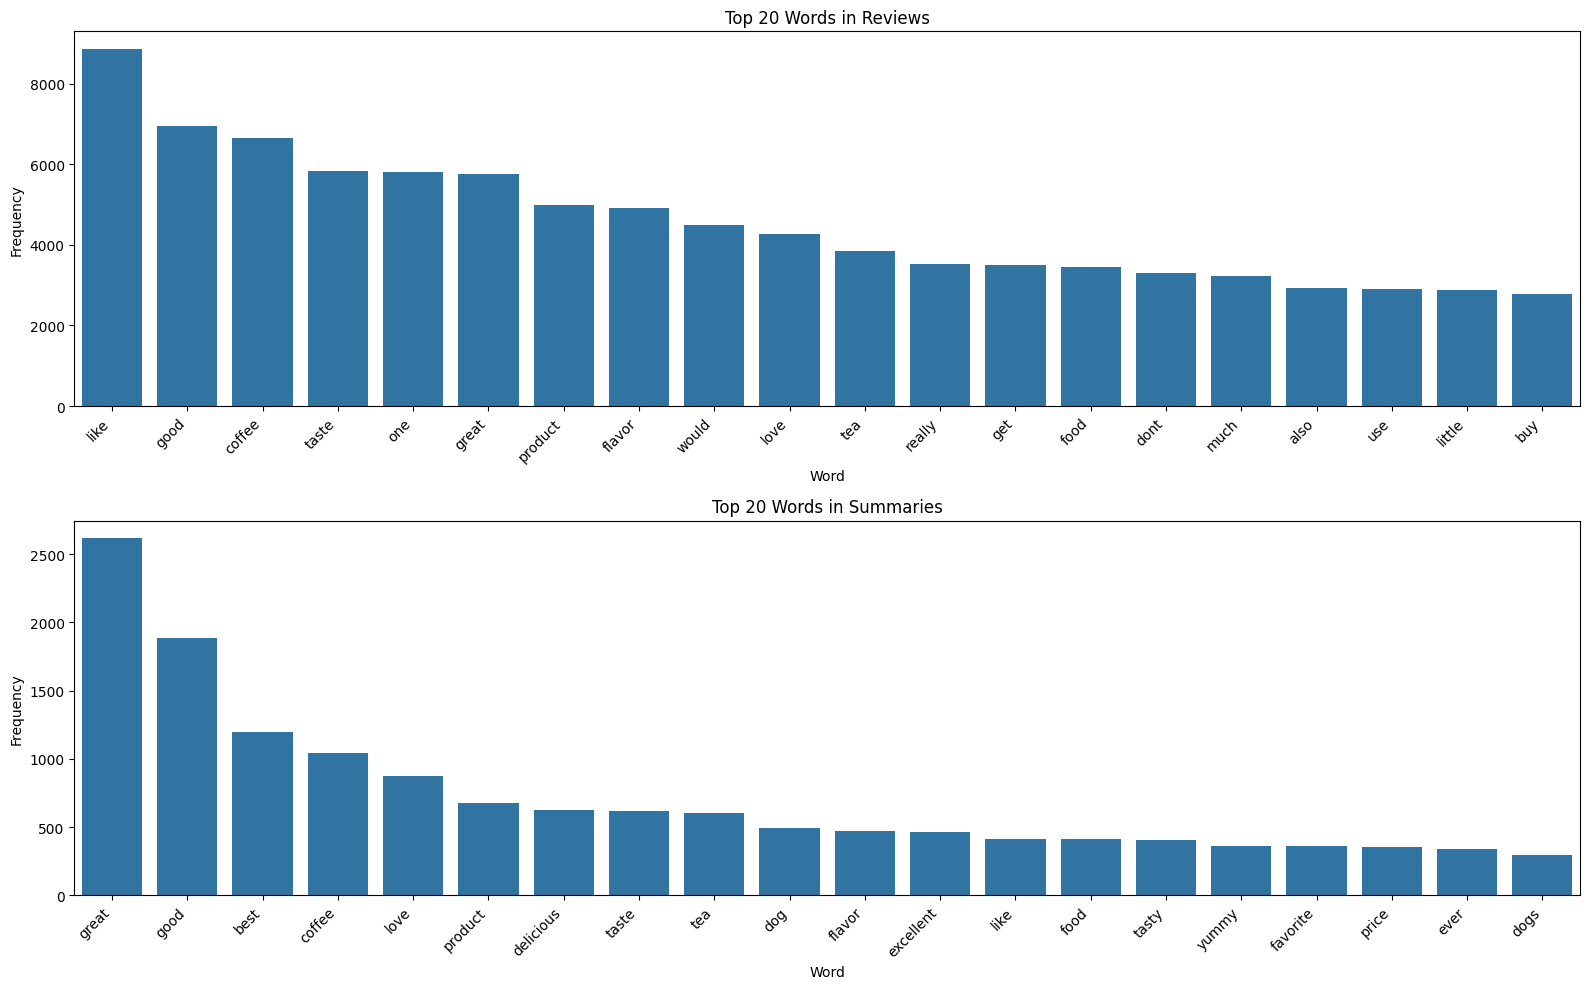

In [28]:
# Get most frequent words
text_freq_words = utils.get_frequent_words(df['Text'])
summary_freq_words = utils.get_frequent_words(df['Summary'])

# Display as DataFrames
text_freq_df = pd.DataFrame(text_freq_words, columns=['Word', 'Frequency'])
summary_freq_df = pd.DataFrame(summary_freq_words, columns=['Word', 'Frequency'])

# Plot frequency distributions
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='Word', y='Frequency', data=text_freq_df.head(20))
plt.title('Top 20 Words in Reviews')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 1, 2)
sns.barplot(x='Word', y='Frequency', data=summary_freq_df.head(20))
plt.title('Top 20 Words in Summaries')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

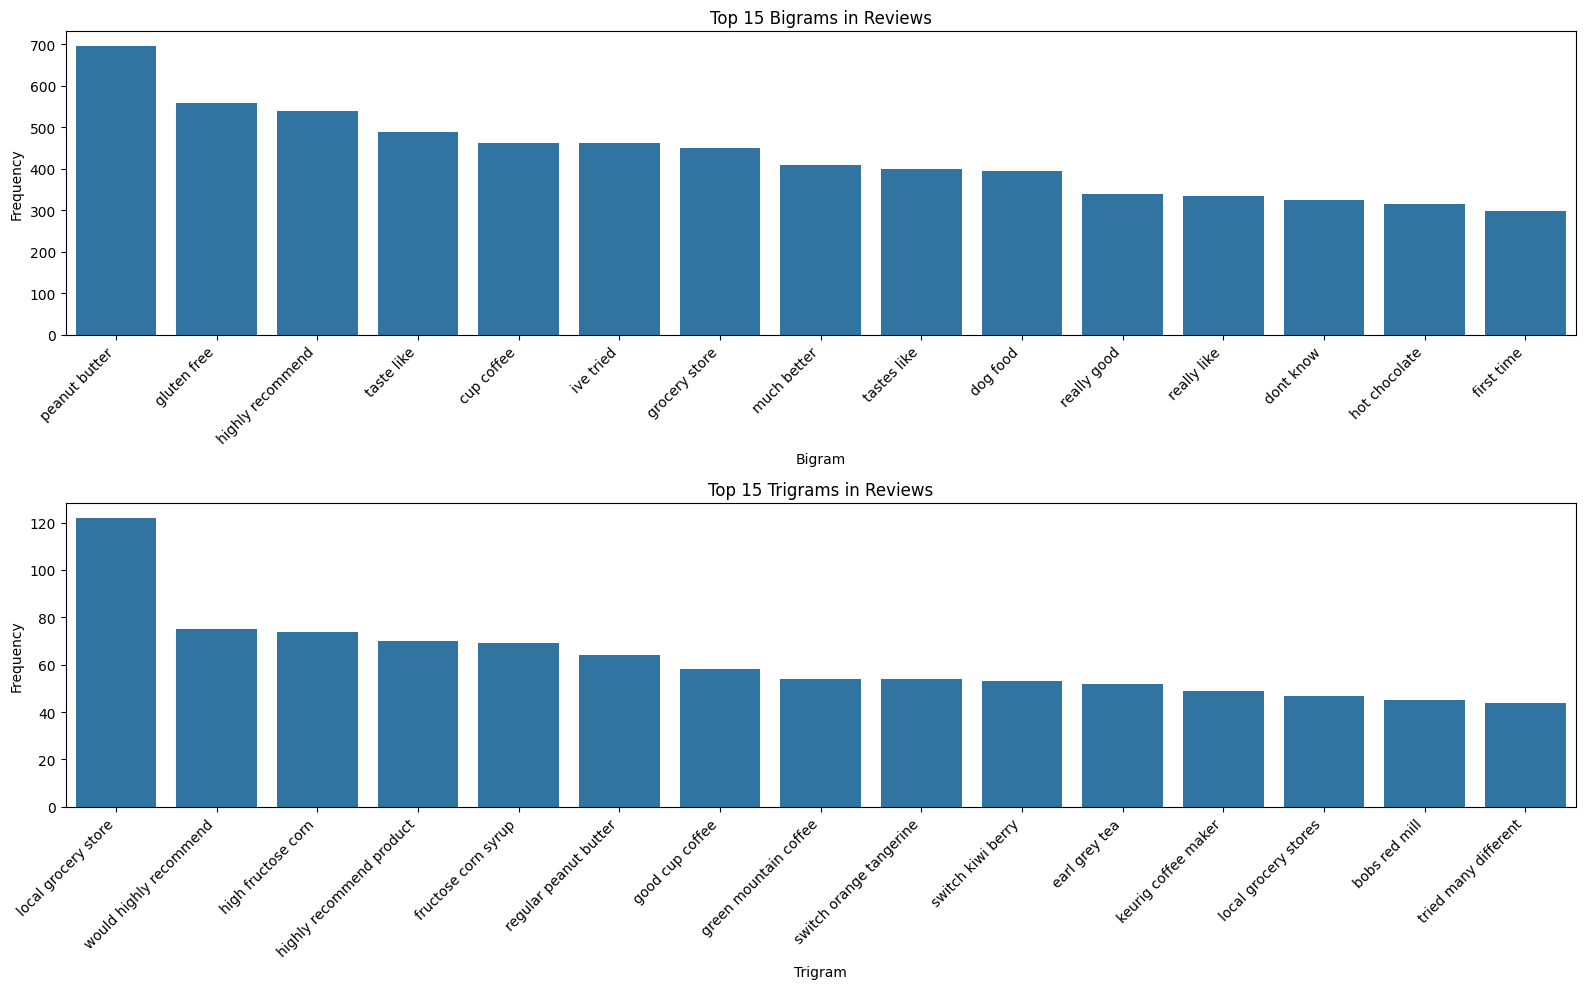

In [29]:
# Get bigrams and trigrams
text_bigrams = utils.get_ngrams(df['Text'], n=2)
text_trigrams = utils.get_ngrams(df['Text'], n=3)

# Display bigrams
bigram_df = pd.DataFrame(text_bigrams, columns=['Bigram', 'Frequency'])
bigram_df['Bigram'] = bigram_df['Bigram'].apply(lambda x: ' '.join(x))

# Display trigrams
trigram_df = pd.DataFrame(text_trigrams, columns=['Trigram', 'Frequency'])
trigram_df['Trigram'] = trigram_df['Trigram'].apply(lambda x: ' '.join(x))

# Plot
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='Bigram', y='Frequency', data=bigram_df.head(15))
plt.title('Top 15 Bigrams in Reviews')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 1, 2)
sns.barplot(x='Trigram', y='Frequency', data=trigram_df.head(15))
plt.title('Top 15 Trigrams in Reviews')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 6.2 Compare Vocabulary Patterns Between High and Low Scores

In [30]:
# Create high and low score dataframes
high_scores_df = df[df['Score'] == 5]
low_scores_df = df[df['Score'].isin([1, 2])]

print(f"Number of high score reviews (5): {len(high_scores_df)}")
print(f"Number of low score reviews (1-2): {len(low_scores_df)}")

Number of high score reviews (5): 12595
Number of low score reviews (1-2): 2951


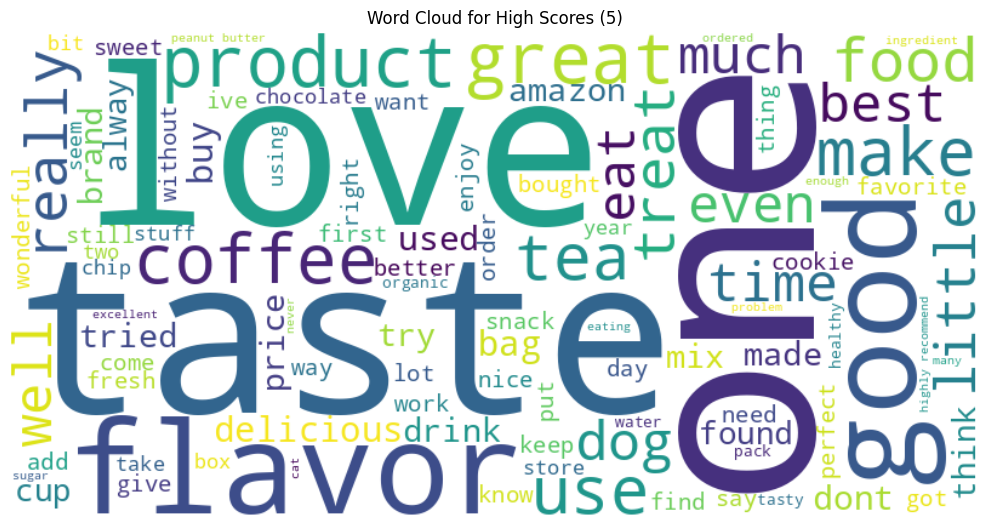

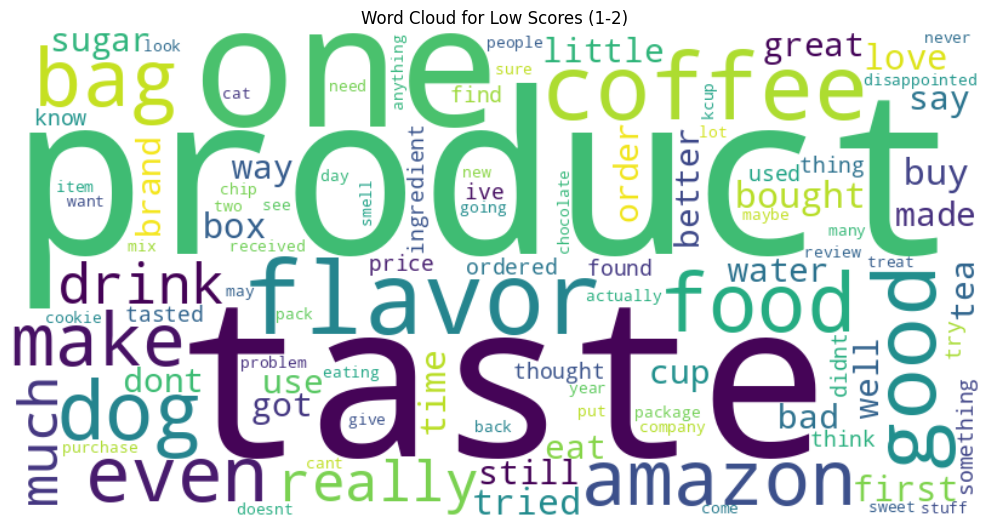

In [31]:
# Generate word clouds for different score categories
utils.generate_wordcloud(high_scores_df['Text'], 'Word Cloud for High Scores (5)')
utils.generate_wordcloud(low_scores_df['Text'], 'Word Cloud for Low Scores (1-2)')

In [32]:
# Get frequent words for different score categories
high_score_words = utils.get_frequent_words(high_scores_df['Text'])
low_score_words = utils.get_frequent_words(low_scores_df['Text'])

# Convert to DataFrames
high_score_df = pd.DataFrame(high_score_words, columns=['Word', 'High Score Frequency'])
low_score_df = pd.DataFrame(low_score_words, columns=['Word', 'Low Score Frequency'])

# Create a combined df for comparison
word_comparison = pd.merge(high_score_df, low_score_df, on='Word', how='outer').fillna(0)

# Calculate proportion of occurrences (normalize by number of reviews)
word_comparison['High Score Proportion'] = word_comparison['High Score Frequency'] / len(high_scores_df)
word_comparison['Low Score Proportion'] = word_comparison['Low Score Frequency'] / len(low_scores_df)

# Calculate difference in proportions
word_comparison['Proportion Difference'] = word_comparison['High Score Proportion'] - word_comparison['Low Score Proportion']

# Display most distinctive words
print("Words more common in high-scoring reviews:")
display(word_comparison.sort_values('Proportion Difference', ascending=False).head(15)[['Word', 'High Score Proportion', 'Low Score Proportion', 'Proportion Difference']])

print("\nWords more common in low-scoring reviews:")
display(word_comparison.sort_values('Proportion Difference').head(15)[['Word', 'High Score Proportion', 'Low Score Proportion', 'Proportion Difference']])

Words more common in high-scoring reviews:


,Word,High Score Proportion,Low Score Proportion,Proportion Difference
19,great,0.348313,0.000000,0.348313
23,love,0.262723,0.000000,0.262723
3,best,0.172688,0.000000,0.172688
37,use,0.151965,0.000000,0.151965
13,find,0.135689,0.000000,0.135689
25,make,0.132037,0.000000,0.132037
22,little,0.127114,0.000000,0.127114
28,price,0.124176,0.000000,0.124176
20,ive,0.123303,0.000000,0.123303
39,well,0.117904,0.000000,0.117904



Words more common in low-scoring reviews:


,Word,High Score Proportion,Low Score Proportion,Proportion Difference
12,even,0.000000,0.190444,-0.190444
40,would,0.158079,0.327347,-0.169268
29,product,0.212465,0.368011,-0.155546
14,first,0.000000,0.143680,-0.143680
21,like,0.372370,0.515757,-0.143387
24,made,0.000000,0.139275,-0.139275
5,bought,0.000000,0.136903,-0.136903
6,box,0.000000,0.132159,-0.132159
31,sugar,0.000000,0.131820,-0.131820
32,taste,0.235728,0.364961,-0.129233


### 6.3 Analyze Special Characters/HTML Tags in Text

In [33]:
# Check for HTML tags in Text and Summary
df['Has_HTML_Tags_Text'] = df['Text'].apply(utils.contains_html_tags)
df['Has_HTML_Tags_Summary'] = df['Summary'].apply(utils.contains_html_tags)

print(f"Number of reviews with HTML tags in Text: {df['Has_HTML_Tags_Text'].sum()}")
print(f"Number of reviews with HTML tags in Summary: {df['Has_HTML_Tags_Summary'].sum()}")

# Display examples if HTML tags exist
if df['Has_HTML_Tags_Text'].sum() > 0:
    print("\nExamples of reviews with HTML tags:")
    display(df[df['Has_HTML_Tags_Text']].head(3)[['Id', 'Score', 'Text']])

Number of reviews with HTML tags in Text: 5185
Number of reviews with HTML tags in Summary: 0

Examples of reviews with HTML tags:


,Id,Score,Text
10,11,5,I don't know if it's the cactus or the tequila...
18,19,5,"Twizzlers, Strawberry my childhood favorite ca..."
21,22,5,I bought these for my husband who is currently...


In [34]:
# Count special characters in Text and Summary
df['Special_Chars_Text'] = df['Text'].apply(lambda x: len(utils.extract_special_chars(x)))
df['Special_Chars_Summary'] = df['Summary'].apply(lambda x: len(utils.extract_special_chars(x)))

# Display statistics
special_chars_stats = pd.DataFrame({
    'Special_Chars_Text': df['Special_Chars_Text'].describe(),
    'Special_Chars_Summary': df['Special_Chars_Summary'].describe()
})

special_chars_stats

,Special_Chars_Text,Special_Chars_Summary
count,20038.000000,20038.000000
mean,17.218285,0.920052
std,23.547966,1.564662
min,0.000000,0.000000
25%,5.000000,0.000000
50%,10.000000,0.000000
75%,20.000000,1.000000
max,538.000000,72.000000


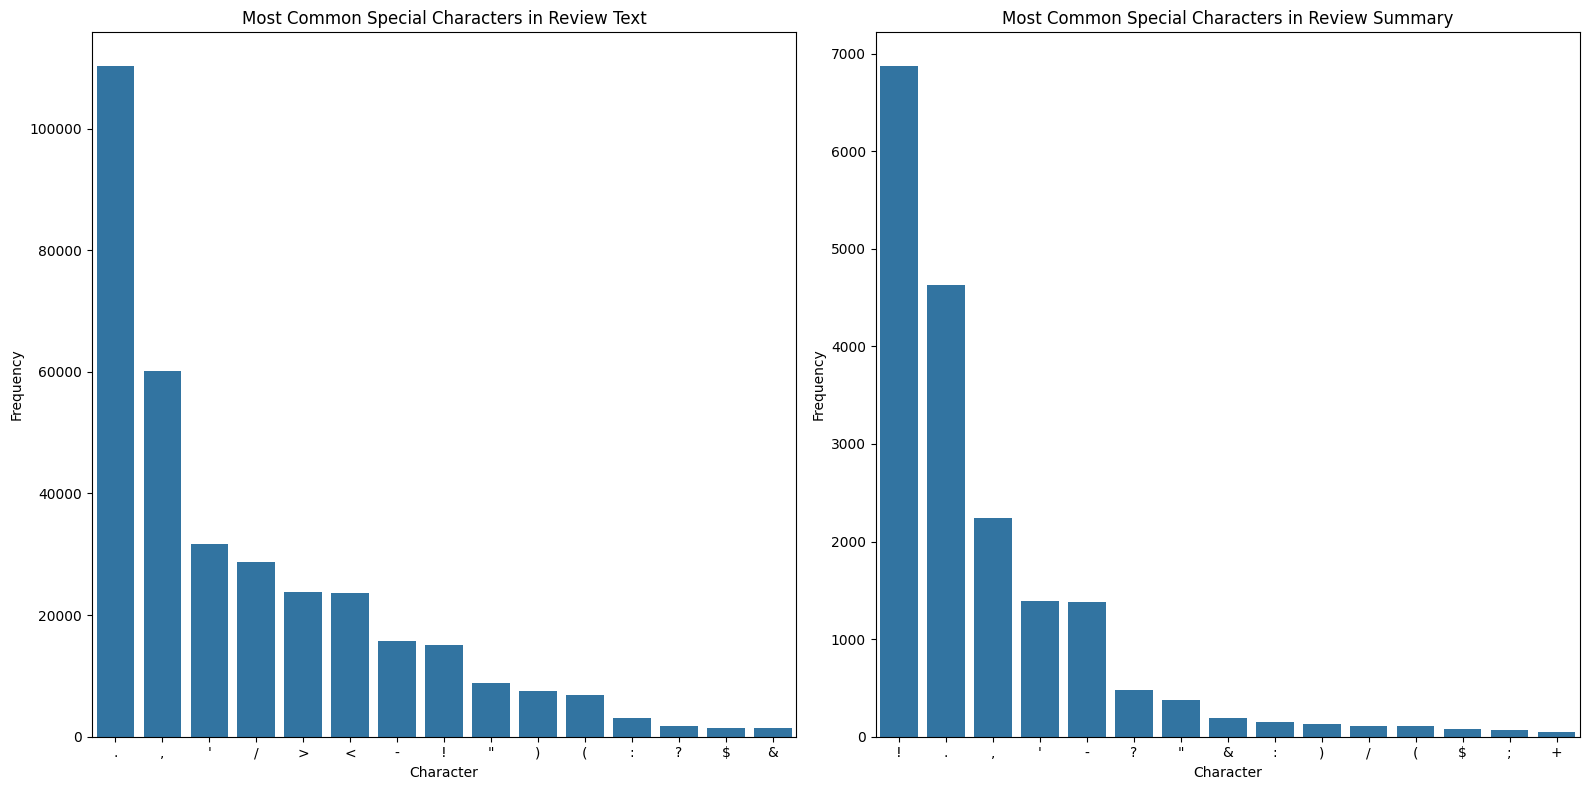

In [35]:
# Analyze most common special characters
all_special_chars_text = ''.join(df['Text'].apply(utils.extract_special_chars))
all_special_chars_summary = ''.join(df['Summary'].apply(utils.extract_special_chars))

# Count frequencies
text_char_counts = Counter(all_special_chars_text).most_common(15)
summary_char_counts = Counter(all_special_chars_summary).most_common(15)

# Convert to dataframes for visualization
text_char_df = pd.DataFrame(text_char_counts, columns=['Character', 'Frequency'])
summary_char_df = pd.DataFrame(summary_char_counts, columns=['Character', 'Frequency'])

# Plot
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.barplot(x='Character', y='Frequency', data=text_char_df)
plt.title('Most Common Special Characters in Review Text')

plt.subplot(1, 2, 2)
sns.barplot(x='Character', y='Frequency', data=summary_char_df)
plt.title('Most Common Special Characters in Review Summary')

plt.tight_layout()
plt.show()

## 7. Metadata Relationships

In this section, we analyze relationships between metadata elements and review scores.

### 7.1 Investigate Correlation between Summary Length and Score

Correlation between Summary Length and Score: -0.0672
Correlation between Text Length and Score: -0.0853


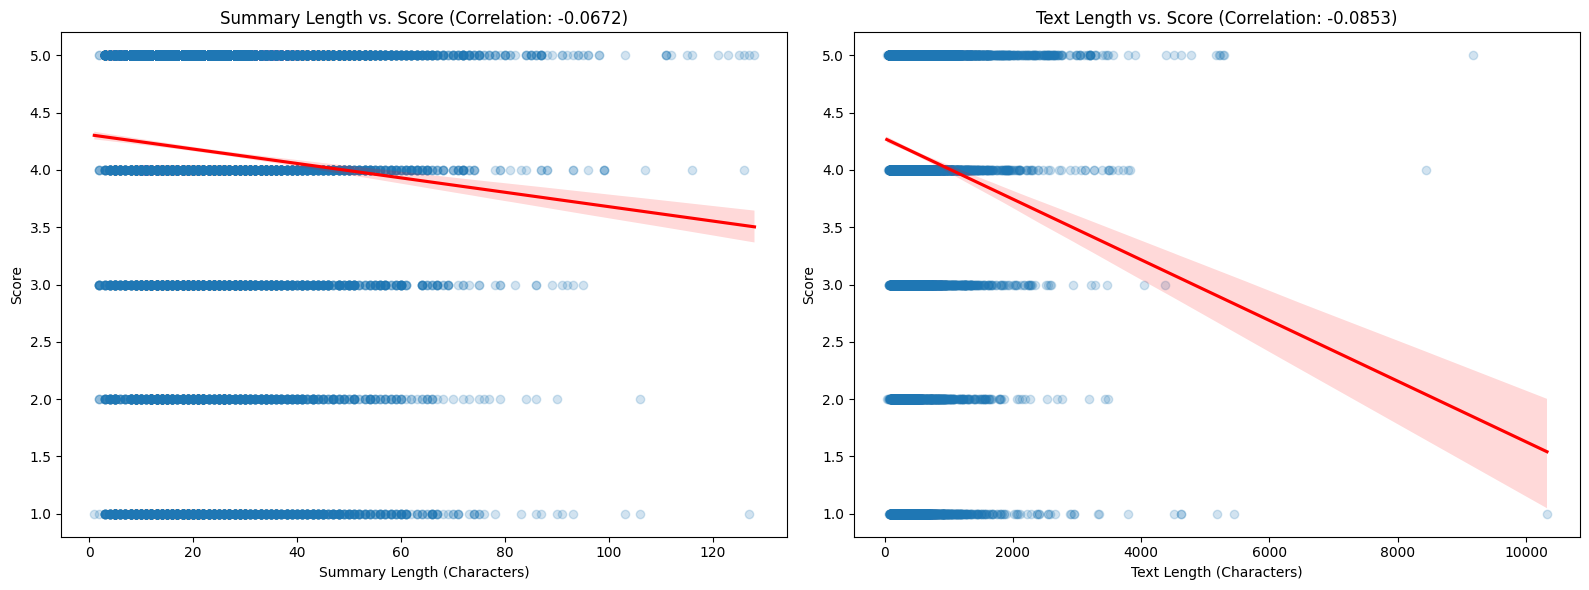

In [36]:
# Calculate correlation between summary length and score
summary_corr = df['Summary_Length'].corr(df['Score'])
text_corr = df['Text_Length'].corr(df['Score'])

print(f"Correlation between Summary Length and Score: {summary_corr:.4f}")
print(f"Correlation between Text Length and Score: {text_corr:.4f}")

# Create scatter plots with regression line
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.regplot(x='Summary_Length', y='Score', data=df, scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title(f'Summary Length vs. Score (Correlation: {summary_corr:.4f})')
plt.xlabel('Summary Length (Characters)')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
sns.regplot(x='Text_Length', y='Score', data=df, scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title(f'Text Length vs. Score (Correlation: {text_corr:.4f})')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

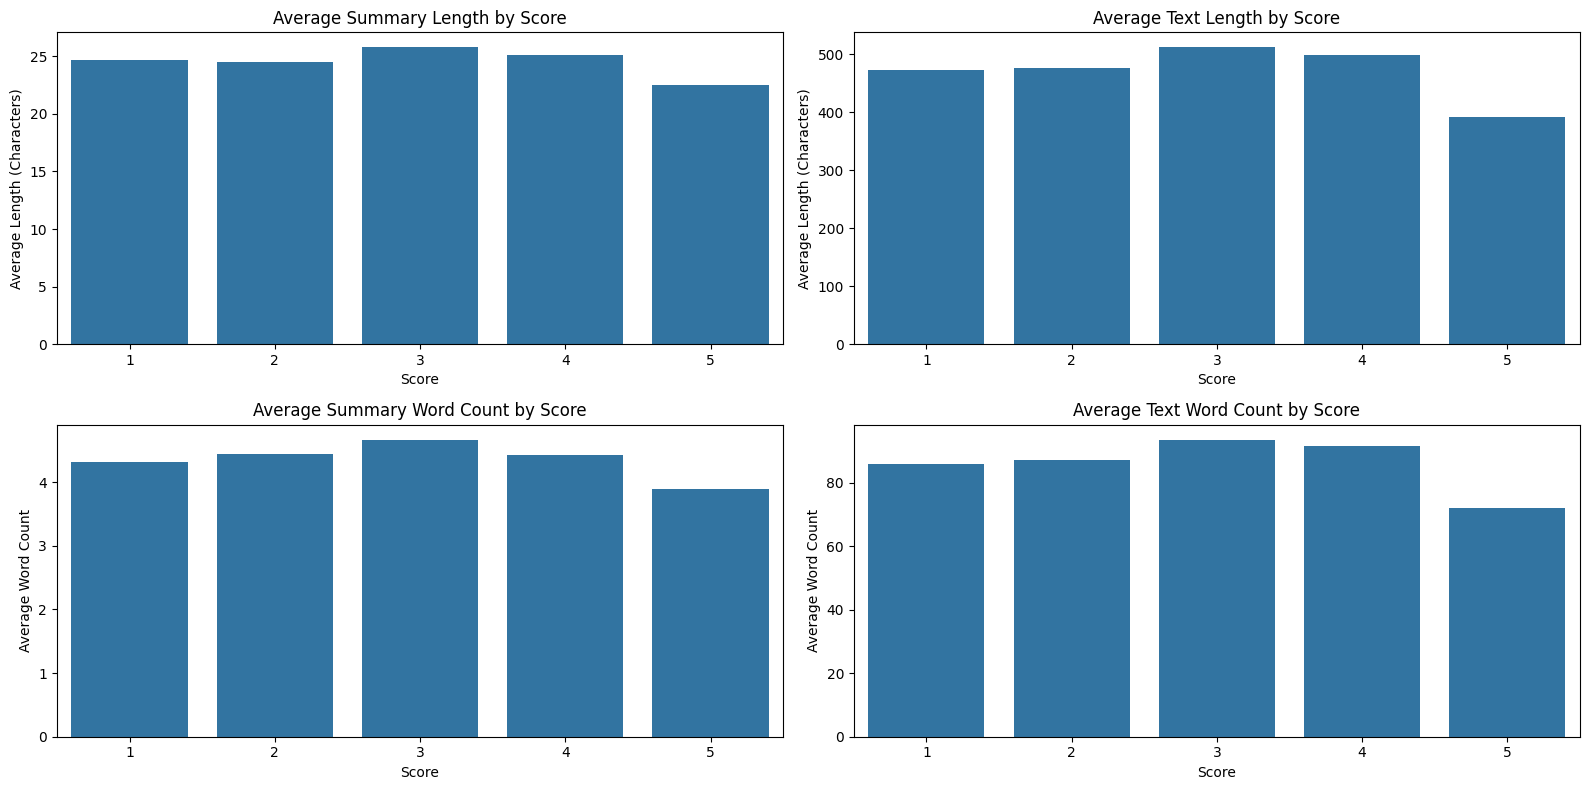

In [37]:
# Calculate average length for each score
length_by_score = df.groupby('Score')[['Summary_Length', 'Text_Length', 'Summary_Word_Count', 'Text_Word_Count']].mean().reset_index()

# Plot average lengths by score
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
sns.barplot(x='Score', y='Summary_Length', data=length_by_score)
plt.title('Average Summary Length by Score')
plt.ylabel('Average Length (Characters)')

plt.subplot(2, 2, 2)
sns.barplot(x='Score', y='Text_Length', data=length_by_score)
plt.title('Average Text Length by Score')
plt.ylabel('Average Length (Characters)')

plt.subplot(2, 2, 3)
sns.barplot(x='Score', y='Summary_Word_Count', data=length_by_score)
plt.title('Average Summary Word Count by Score')
plt.ylabel('Average Word Count')

plt.subplot(2, 2, 4)
sns.barplot(x='Score', y='Text_Word_Count', data=length_by_score)
plt.title('Average Text Word Count by Score')
plt.ylabel('Average Word Count')

plt.tight_layout()
plt.show()

### 7.2 Check if Empty Summaries Exist and Their Score Distribution

In [38]:
# Check for empty summaries
empty_summary_mask = (df['Summary'].isnull()) | (df['Summary'] == '') | (df['Summary'].str.strip() == '')
empty_summaries = df[empty_summary_mask]

print(f"Number of reviews with empty summaries: {len(empty_summaries)}")
print(f"Percentage of reviews with empty summaries: {len(empty_summaries) / len(df) * 100:.2f}%")

# Analyze score distribution for empty summaries
if len(empty_summaries) > 0:
    empty_score_counts = empty_summaries['Score'].value_counts().sort_index()
    empty_score_percentage = empty_summaries['Score'].value_counts(normalize=True).sort_index() * 100
    
    empty_score_dist = pd.DataFrame({
        'Count': empty_score_counts,
        'Percentage (%)': empty_score_percentage
    })
    
    print("\nScore distribution for reviews with empty summaries:")
    display(empty_score_dist)
    
    # Visualize
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.countplot(x='Score', data=empty_summaries)
    plt.title('Score Distribution for Empty Summaries')
    
    plt.subplot(1, 2, 2)
    overall_percentages = df['Score'].value_counts(normalize=True).sort_index() * 100
    empty_percentages = empty_score_percentage
    
    # Create comparison dataframe
    comparison = pd.DataFrame({
        'All Reviews': overall_percentages,
        'Empty Summaries': empty_percentages
    }).fillna(0).reset_index().rename(columns={'index': 'Score'})
    
    comparison_melted = comparison.melt(id_vars='Score', var_name='Category', value_name='Percentage')
    sns.barplot(x='Score', y='Percentage', hue='Category', data=comparison_melted)
    plt.title('Score Distribution Comparison')
    plt.ylabel('Percentage (%)')
    
    plt.tight_layout()
    plt.show()

Number of reviews with empty summaries: 0
Percentage of reviews with empty summaries: 0.00%


### 7.3 Compare Text Length Distributions Across Different Scores

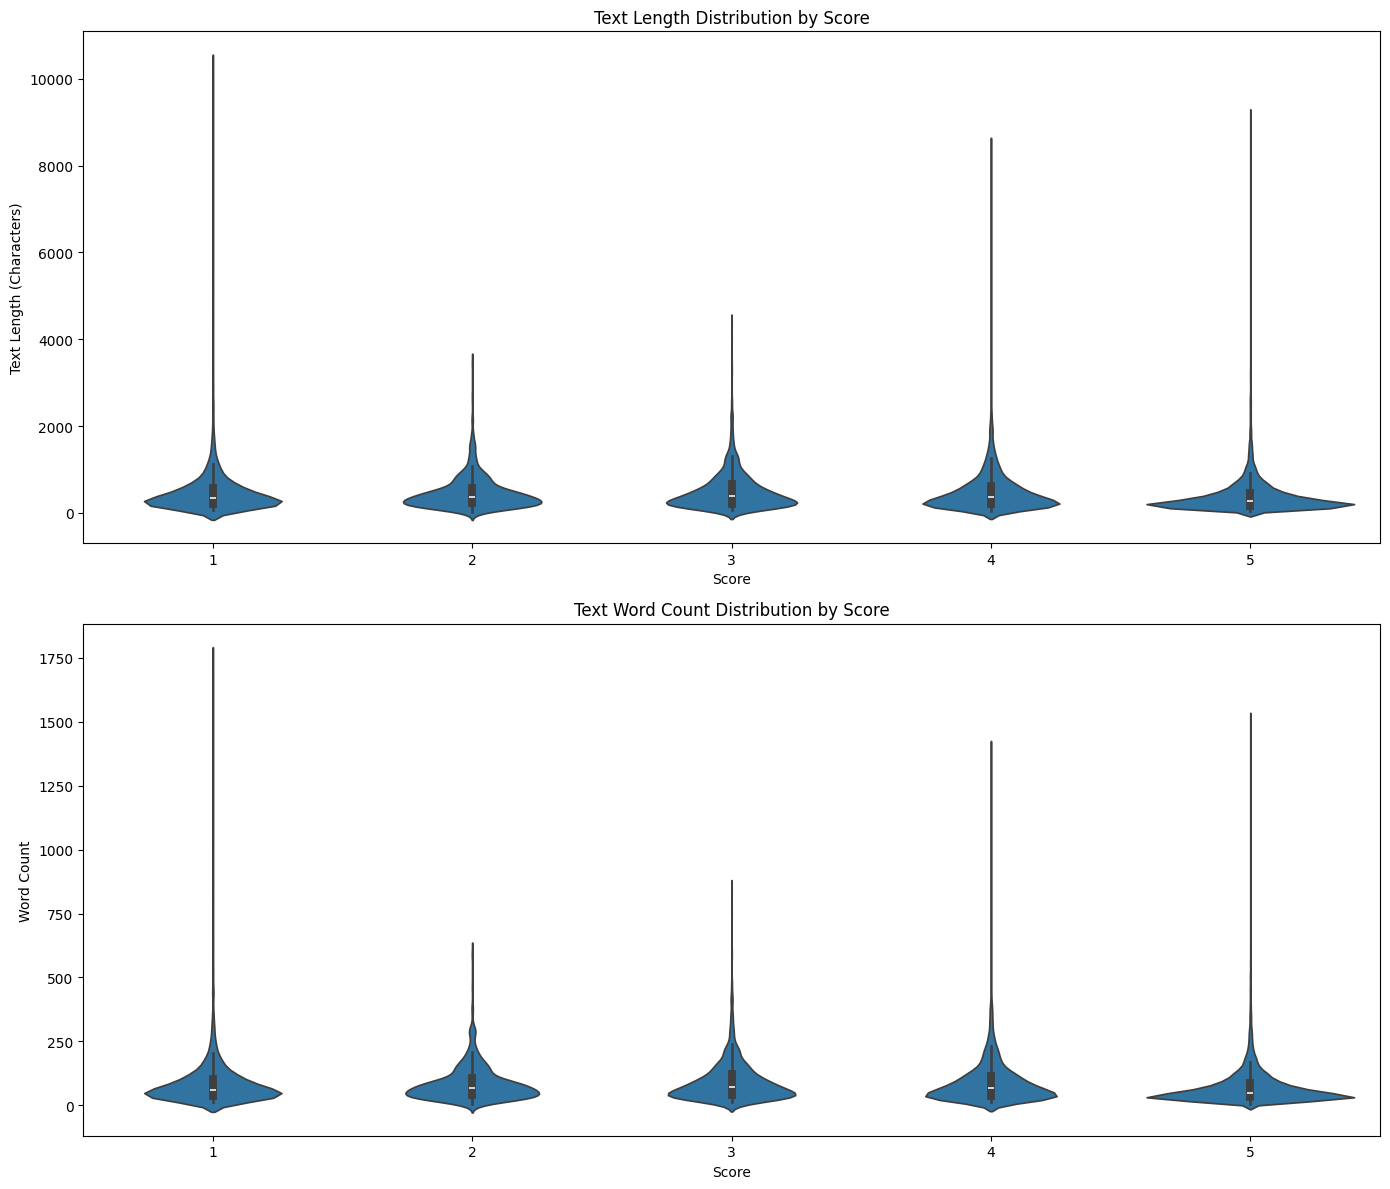

In [39]:
# Create violin plots for text length distributions by score
plt.figure(figsize=(14, 12))

plt.subplot(2, 1, 1)
sns.violinplot(x='Score', y='Text_Length', data=df)
plt.title('Text Length Distribution by Score')
plt.ylabel('Text Length (Characters)')

plt.subplot(2, 1, 2)
sns.violinplot(x='Score', y='Text_Word_Count', data=df)
plt.title('Text Word Count Distribution by Score')
plt.ylabel('Word Count')

plt.tight_layout()
plt.show()

In [40]:
# Test if the differences are statistically significant
from scipy import stats

# ANOVA test for Text_Length across different scores
score_groups = [df[df['Score'] == i]['Text_Length'].dropna() for i in range(1, 6)]
f_stat, p_value = stats.f_oneway(*score_groups)

print(f"ANOVA Test for Text Length by Score:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.8f}")
print(f"Statistically significant difference: {'Yes' if p_value < 0.05 else 'No'}")

ANOVA Test for Text Length by Score:
F-statistic: 68.5870
p-value: 0.00000000
Statistically significant difference: Yes


## Summary of Findings

1. **Missing Values**: No missing values found in Score, Summary, or Text columns (0%).

2. **Duplicate Entries**: No exact duplicate rows detected, but 695 content duplicates (same Score, Summary, and Text with different IDs), representing approximately 3.47% of the dataset.

3. **Data Types**: All columns have appropriate data types. Score is numerical (int64), and both Summary and Text are objects (strings).

4. **Score Distribution**: Strong class imbalance with 62.86% of reviews having Score=5. The distribution is:
   - Score 1: 9.13%
   - Score 2: 5.60%
   - Score 3: 8.24%
   - Score 4: 14.17%
   - Score 5: 62.86%

5. **Text Length Statistics**: 
   - Summary: mean=23.42 chars/4.10 words, max=128 chars/31 words
   - Text: mean=428.80 chars/78.68 words, max=10,327 chars/1,751 words
   - Wide variability in review text lengths

6. **Text Content Analysis**:
   - Most frequent positive-review words: "great", "love", "best", "use", "find"
   - Most frequent negative-review words: "even", "would", "product", "first", "like" 
   - 25.9% of reviews (5,185) contain HTML tags in Text field, none in Summary
   - Average of 17.22 special characters per review

7. **Metadata Relationships**:
   - Weak negative correlations between text length and score (Summary: -0.0672, Text: -0.0853)
   - No empty summaries found
   - Statistically significant differences in text length across score categories (ANOVA p-value < 0.00000001)

Based on these findings, recommendations for data preprocessing include:
- Handling content duplicates (consider removing or flagging them)
- Addressing class imbalance through resampling or weighted loss functions
- Cleaning HTML tags from review texts (affecting ~26% of entries)
- Considering length normalization, particularly for outliers (max text length is 24× the mean)
- Implementing sentiment analysis leveraging the vocabulary differences identified between high/low-scoring reviews
- Using the correlation between `text length` and `score` as a potential feature